<a href="https://colab.research.google.com/github/ShengpeiWang/kick-with-bert/blob/master/kick_roberta_fastai2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kickstarter project classification using tranfer learning with the RoBERTa model
In the previous iterations of the project, I have struggled with model performance, and TF-IDF and ULMfit both performed suboptimally. I have have been learning about more modern NLP techniques, and I am going to apply the RoBERTa model to my kickstarter data using HuggingFace.



In [1]:
# remember to turn the GPU on
# first install the tranformers library where the RoBERTa model info is
%%bash
pip install transformers

  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=23a9fbb73b29335479d5dce50e82c0825a02d53df872134d9ed4f522fb98bf4b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# set up other dependencies
# for data input and output
from google.colab import drive
import pickle
import pandas as pd

# for visualization
import seaborn as sns

# for model building and fitting
import torch
from fastai.text import *
from fastai.metrics import *

# for getting the pretrained model and tokenizer of the Roberta model
from transformers import RobertaTokenizer, RobertaModel

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import and preprocess the data


In [3]:
# local drive set up, so I can access data in Googel drive 
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/kick'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Load the Kickstarter data
- I split the proposal text into sentences and kept the first five sentences that were at least 20 characters long. I did this because Bert type models works best on short to medium lenghted text, and the beginning of a proposal is the most important.      
- Code for the data cleaning can be found in another file.

In [4]:
with open(base_dir + "/project_data_sentences_train.pkl", "rb") as f:
  data_train = pickle.load(f)

with open(base_dir + "/project_data_sentences_test.pkl", "rb") as f:
  data_test = pickle.load(f)

In [5]:
data_train.dtypes

project_id          int64
story_tb           object
l_pledge          float64
performance_s    category
dtype: object

## Determine maximum token length
- Since Roberta works with fixed input lenght, it's importnat to pick a number that's appropriate

In [6]:
# Download the pretrained tokenizer and model
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
#roberta_model = RobertaModel.from_pretrained("roberta-base")

In [7]:
# visualize the token length of the data
token_lens = []

for txt in data_train['story_tb']:
  tokens = roberta_tokenizer.encode(txt, truncation = True, max_length = 512)
  token_lens.append(len(tokens))

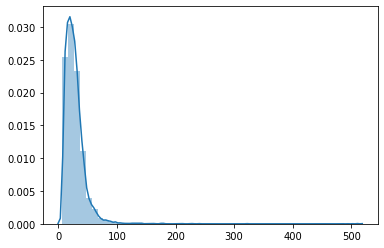

In [8]:
sns.distplot(token_lens)
# the max seq lenght should be around 100

## Define classes that would allow the tokenizer to work with fastai's data structure
- fastai implements some really useful utilities for model training
- including learning rate finder, gradual unfreeze of a model, and triangular learning rates

In [9]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer, max_len, **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = max_len

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [10]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

In [11]:
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = roberta_tokenizer, max_len = 100)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

In [12]:
transformer_vocab =  TransformersVocab(tokenizer = roberta_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab = transformer_vocab)

transformer_processor = [tokenize_processor, numericalize_processor]

## Creat the databunch:
- bind training and testing data in a data object
- includes preprocessing (apply the tokenizer), identifying features and lables, and creating dataloaders
- puts the dataloaders on device

In [13]:
pad_first = False
pad_idx = roberta_tokenizer.pad_token_id
bs = 8

# process the data: 
databunch = (TextList.from_df(data_train, cols=['story_tb'], processor=transformer_processor)
             .split_by_rand_pct(0.1)
             .label_from_df(cols=['performance_s'])
             .add_test(data_test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [14]:
databunch.show_batch()

text,target
"<s> Ġflux Ġstate Ġ Ġvit o Ġsc ole tta Ġis Ġa Ġhip - hop Ġartist Ġfrom Ġsouthern Ġcal if ornia , Ġhe Ġhas Ġcreated Ġshock - waves Ġthroughout Ġthe Ġhip - hop Ġcommunity Ġwith Ġhis Ġrive ting Ġclub Ġperformances Ġand Ġthe Ġhit Ġsong Ġ20 34 , Ġafter Ġthe Ġsuccess Ġof Ġ2016 's Ġ"" da Ġboom Ġb ap Ġtapes "" Ġhe Ġis Ġcurrently Ġworking Ġon Ġhis Ġsecond Ġmix - t ape",1
"<s> Ġraspberry Ġpi Ġand Ġpython Ġ( or Ġany Ġother Ġlanguage ) ard u ino esp 8 266 Ġ( e . g . Ġwe mos Ġd 1 Ġmini ) att iny Ġ( e . g . Ġdig isp ark ) you Ġcould Ġeven Ġcontrol Ġit Ġfrom Ġyour Ġphone , Ġif Ġconnected Ġto Ġwifi - enabled Ġdevice Ġlike Ġthe Ġpi Ġzero Ġw . Ġopen Ġa Ġport Ġon Ġyour Ġrouter Ġand Ġyou Ġcould",4
"<s> ĠExp anding Ġhealthy Ġfood Ġcatering ĠTrailer Ġ- Ġhealthy Ġlun ches Looking Ġto Ġprovide Ġa Ġhealthy Ġfood Ġtruck Ġlunch Ġoption Ġfor Ġcity Ġworkers Ġand Ġwe Ġneed Ġstore Ġand Ġserve Ġif Ġfrom Ġa Ġrefriger ated Ġtrailer about Ġour Ġhealthy Ġlunch Ġoptions Ġin Ġto days Ġhe ctic Ġlifestyle Ġwe Ġtend Ġto Ġwant Ġto Ġeat Ġhealthy Ġbut Ġoften Ġdon 't Ġhave Ġthe Ġtime Ġto Ġprepare Ġhealthy Ġmeals , Ġso Ġwe Ġwant Ġto Ġtake",0
"<s> Ġt ai Ġgood en Ġof Ġsy fy Ġwire Ġinterviews Ġmoon Ġf erguson l il ith Ġd or sey Ġof Ġv oodoo Ġuniverse Ġsits Ġdown Ġwith Ġdirector , Ġmoon Ġf erguson la uren Ġbull ock Ġof Ġblack Ġnerd Ġproblems Ġsits Ġdown Ġwith Ġthe Ġmain Ġwitches er in Ġwhite Ġof Ġaf rop unk Ġcovers Ġju ju : Ġthe Ġweb Ġseries j ordan Ġsim on Ġof Ġshadow Ġ& Ġact Ġcovers Ġju ju",4
"<s> ĠK A ĠLA ' AU ĠK A UK A Ġ( ĠTHE ĠW OOD ĠDO CT OR Ġ) ĠW OOD WORK ĠFROM ĠA - Z CRE ATIVE ĠW OOD WORK ER Ġ, THIS ĠPRO JECT ĠCOM ES ĠFROM ĠPEOPLE ĠHELP ING ĠME ĠIN ĠW OOD WORK ING Ġ, TIME ĠTO ĠG IVE ĠBACK Ġ, I ĠW OULD ĠHAVE ĠBE EN ĠL OST ĠWITHOUT ĠTHEM the Ġshop Ġi Ġhave Ġpicked Ġout",0


In [15]:
databunch.one_batch()[0]

tensor([[    0,  1446,  1761,    36,  3746,   359,  1331,  3256,  1437,  1437,
          1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,
          1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,
          1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,
          1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,
          1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,
          1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,
          1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,
          1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,    36,
          3746,     8,  1331, 21416,    12, 17742, 40457,     6,   697,     2],
        [    0,    34,    70,  3505,     9, 10954,  6272,    31, 45387,     7,
          3222, 47987,  2368, 13206, 15253, 30837,   145,     6, 25779,     6,
          8375,     6,  1925,     6, 43739,     6, 

## Define the classification model
- use the pretrained roberta model as the encoder
- add a classification head (a linear layer)
- define sections that will be pregressively unfreezed during training

In [16]:
class RobertaClassifier(torch.nn.Module):

  def __init__(self, num_labels = 4):
    super(RobertaClassifier, self).__init__()
    self.roberta = roberta_model
    self.drop = torch.nn.Dropout(p = dropout_prob)
    self.classifier = torch.nn.Linear(self.roberta.config.hidden_size, num_labels) # defining final output layer

  def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
    _, pooled_output = self.roberta(input_ids, token_type_ids, attention_mask)
    output = self.drop(pooled_output) 
    logits = self.classifier(pooled_output)
    return logits

In [17]:
roberta_model = RobertaModel.from_pretrained("roberta-base")

In [18]:
dropout_prob = 0.05
fastai_model = RobertaClassifier()

In [19]:
learner = Learner(databunch, fastai_model, metrics=[accuracy])

In [20]:
# Check model structure
learner.model

RobertaClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [21]:
# Split the 14 layers we have
# 1 embedding, 12 transformer, 1 classifier
list_layers = [learner.model.roberta.embeddings,
              learner.model.roberta.encoder.layer[0],
              learner.model.roberta.encoder.layer[1],
              learner.model.roberta.encoder.layer[2],
              learner.model.roberta.encoder.layer[3],
              learner.model.roberta.encoder.layer[4],
              learner.model.roberta.encoder.layer[5],
              learner.model.roberta.encoder.layer[6],
              learner.model.roberta.encoder.layer[7],
              learner.model.roberta.encoder.layer[8],
              learner.model.roberta.encoder.layer[9],
              learner.model.roberta.encoder.layer[10],
              learner.model.roberta.encoder.layer[11],
              learner.model.roberta.pooler]

learner.split(list_layers);

In [22]:
len(learner.layer_groups)

14

## Training the model

In [30]:
model_dir = base_dir + "/models/"

In [31]:
learner.freeze_to(-1)

In [32]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


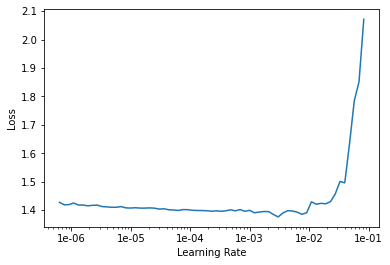

In [33]:
learner.recorder.plot()

In [34]:
 learner.fit_one_cycle(1, max_lr = 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.326620,1.314627,0.361882,00:22


In [35]:
learner.fit_one_cycle(2, max_lr = 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.316278,1.301348,0.364294,00:22
1,1.311104,1.298728,0.382388,00:21


In [36]:
learner.save(model_dir + '-1_3', return_path=True) # 3 epochs layer -1

PosixPath('/content/gdrive/My Drive/fastai-v3/kick/models/-1_3.pth')

In [37]:
learner.freeze_to(-3)

In [38]:
learner.fit_one_cycle(2, max_lr = 5e-5)
 # unfreezing to the trasformer layers does a lot for improving model performance

epoch,train_loss,valid_loss,accuracy,time
0,1.267024,1.207918,0.433052,00:32
1,1.163725,1.163233,0.452352,00:32


In [39]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


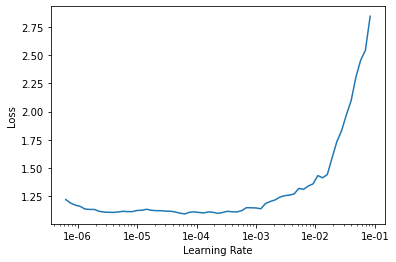

In [40]:
learner.recorder.plot()

In [41]:
learner.fit_one_cycle(3, max_lr = 5e-5)

epoch,train_loss,valid_loss,accuracy,time
0,1.223071,1.167467,0.468034,00:30
1,1.098189,1.160182,0.465621,00:32
2,0.987668,1.175220,0.474065,00:29


In [42]:
learner.save(model_dir + '-2_5', return_path=True) # layer -3, 5 epochs

PosixPath('/content/gdrive/My Drive/fastai-v3/kick/models/-2_5.pth')

In [43]:
learner.freeze_to(-5)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


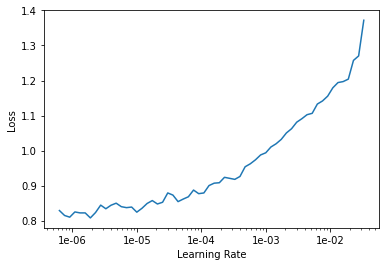

In [44]:
learner.lr_find()
learner.recorder.plot()

In [45]:
learner.fit_one_cycle(3, max_lr = 1e-6)
# the model is overfitting, I will stop now

epoch,train_loss,valid_loss,accuracy,time
0,0.943286,1.192013,0.476478,00:43
1,0.925233,1.204313,0.476478,00:41
2,0.948856,1.204376,0.480096,00:43
